# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Partial-Bayes" data-toc-modified-id="Partial-Bayes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Partial Bayes</a></div><div class="lev1 toc-item"><a href="#Slice-Sampling" data-toc-modified-id="Slice-Sampling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Slice Sampling</a></div><div class="lev1 toc-item"><a href="#Toeplitz-Structure" data-toc-modified-id="Toeplitz-Structure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Toeplitz Structure</a></div><div class="lev2 toc-item"><a href="#Optimisation-using-Toeplitz" data-toc-modified-id="Optimisation-using-Toeplitz-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimisation using Toeplitz</a></div><div class="lev1 toc-item"><a href="#Autodiff" data-toc-modified-id="Autodiff-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autodiff</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbf{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \newcommand{\bnaive}{\widehat{\beta}}
    \newcommand{\bbayes}{\widetilde{\beta}}
    \newcommand{\bboot}{\beta^{*}}
    \newcommand{\bdouble}{\beta^{**}}
    \newcommand{\bbootnv}{\hat{\beta}^*}
    \newcommand{\bbootby}{\widetilde{\beta}^*}
    \newcommand{\bcorrect}{\beta^{\checkmark}}
    \newcommand{\bbayescorrect}{\widetilde{\beta}^{\checkmark}}
    \newcommand{\ybar}{\bar{Y}}
    \newcommand{\ypred}{\widetilde{y}}
    \newcommand{\ybarpred}{\widetilde{\bar{Y}}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\thresh}{\ybar{}_0}
    \newcommand{\muo}{\mu_{0}}
    \newcommand{\sigo}{\sigma_{0}}
    \newcommand{\hmt}{\bar{Y_t}}
    \newcommand{\hst}{s_t^2}
    \newcommand{\hmc}{\bar{Y_c}}
    \newcommand{\hsc}{s_c^2}
    \newcommand{\mt}{\mu_t}
    \newcommand{\sigt}{\sigma_t}
    \newcommand{\vt}{\sigma_t^2}
    \newcommand{\mc}{\mu_c}
    \newcommand{\vc}{\sigma_c^2}
    \newcommand{\sigc}{\sigma_c}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
$$

In [63]:
using Distributions
using PDMats
using Optim
using StatsFuns: log2π
import PyPlot; plt=PyPlot
using DualNumbers
using Gadfly
using ToeplitzMatrices
plt.svg(true)
using Mamba
using GraphViz
using GaussianProcesses
using ProfileView
;

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/ProfileView.ji for module ProfileView.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/ProfileViewSVG.ji for module ProfileViewSVG.


In [2]:
# function sqexp{S<:Number,T<:Number}(σ_f::S, L::T)
#     function k{T<:Number}(x::T, xprime::T)
#         return σ_f^2 * exp( - (x-xprime)^2 / (2*L^2))
#     end
#     return k
# end

function kernel{T<:Number,Kern<:Kernel}(kern::Kern, x::AbstractVector{T})
    n = length(x)
    Xmat = reshape(x, (1,n))
    Σ = GaussianProcesses.crossKern(Xmat, kern)
    return Σ
end

kernel (generic function with 1 method)

Sample 200 points uniformly on either side of the discontinuity at $x=5$.
\begin{align}
    X_1 &\sim \unif\del{0,5}\\
    X_2 &\sim \unif\del{5,10}\\
\end{align}

In [3]:
_X1distr = Uniform(0,5)
_X2distr = Uniform(5,10)
_n_per_region = 200
_n = _n_per_region*2
_thresh = 5.0
_X = sort(Float64[rand(_X1distr, _n_per_region); rand(_X2distr, _n_per_region)])
;

We want to simulate a GP; we'll simulate from the model 
$$y = \tau \Ind\cbr{x>5} + X\beta + \epsilon$$
$X$ will be the locations, and $y$ will be the response surface. 
The shift term $\tau \Ind\cbr{x>5}$ will be zero to the left of the boundary, and
a constant to the right of the boundary.
$\epsilon$ is from a GP with a squared exponential covariance with additional iid normal noise with variance $\sigma_y^2$.

$$ K\del{x,x'} = \cov\del{y, y'} = \sigma_y^2 \delta\del{x-x'} + \sigma_{GP}^2 \exp\del{ - \frac{\del{x-x'}}{2 L^2}} $$


Set the data-generating parameters to the following (arbitrary) values:
\begin{align}
    \sigma_f^2 &= 1 \\
    L^\star &= 1.05 \\
    \tau^\star &= 0.75 \\
    \beta^\star &= 1.0 \\
    \sigma_y^{2\star} &= 0.01 \\
\end{align}

In [4]:
# data-generating parameters
_σf2_star = 1.0
_Lstar  = 1.05
_τstar = 0.75
_βstar = 1.0
_σy2_star = 0.01
_region = _X.>_thresh
;

We are fitting a Bayesian model with normal priors on $\beta$ and $\tau$. Let's start by giving them very diffuse normal priors. The normality allows us to use all the tools of multivariate normal theory.

In [5]:
function simulate1{T<:Number,S<:Number,Ker<:Kernel}(β::T, τ::T, kern::Ker, σy2::T, thresh::Real, X::AbstractVector{S})
    region = X.>thresh
    n = length(X)
    K = kernel(kern, X) + 1e-5*eye(n)
    fXdistr = MvNormal(zeros(n), K)
    fX = rand(fXdistr)
    In=eye(Diagonal{Float64},n)
    Z_Ydistr = Normal(0,√(σy2))
    Y = fX .+ β*X + τ*region .+ rand(Z_Ydistr, n)
    return Y
end

simulate1 (generic function with 1 method)

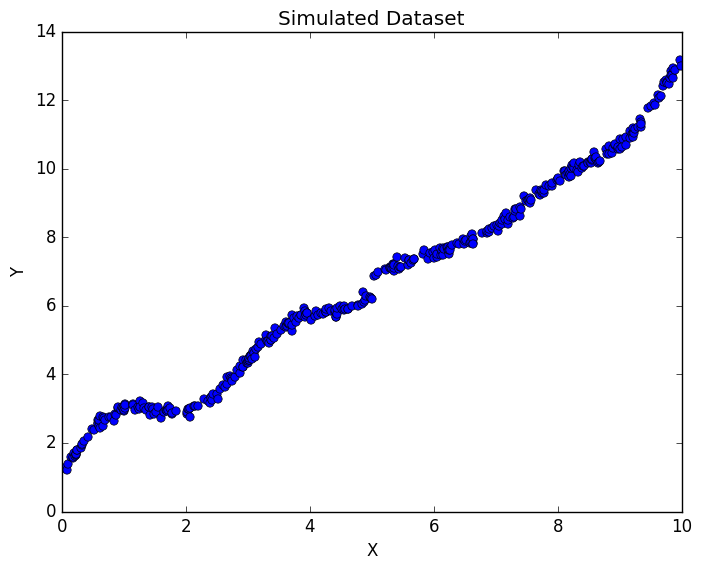

In [59]:
_σβ2 = 1000.0 # extremely diffuse normal prior on β
_στ2 = 1000.0 # extremely diffuse normal prior on τ
_kern = SE(log(_Lstar), log(√_σf2_star))
_II = _region * _region'
_Y = simulate1(_βstar, _τstar, _kern, _σy2_star, _thresh, _X)
plt.plot(_X, _Y, "o")
plt.title("Simulated Dataset")
plt.xlabel("X")
plt.ylabel("Y")
;

Conditionally on $\sigma_y^2$, $\sigma_f^2$ and $L$, the posterior of $\tau$ (i.e. $\tau \mid Y, \sigma_y^2, \sigma_f^2, L$) can be obtain analytically.

We have:
\begin{align}
    \tau &\sim \normal\del{0,\sigma_\tau^2} \\
    \beta &\sim \normal\del{0,\sigma_\beta^2} \\
    Y &= \tau \Ind\cbr{x>5} + X\beta + \underbrace{GP\del{0,K}}_{f} + \epsilon_{iid} \\
    \cov\del{Y,\tau} &= \sigma_\tau \begin{pmatrix}
                                        0 \\
                                        \vdots \\
                                        0 \\
                                        1 \\
                                        \vdots \\
                                        1
                                        \end{pmatrix} \\
    \cov\del{Y,\beta} &= \sigma_\beta X \\
    \cov\del{Y,\tau}\cov\del{Y,\tau}^T &= \sigma_\tau^2 \Ind\cbr{x>5} \Ind\cbr{x>5}^T = \sigma_\tau^2 
            \begin{bmatrix}
                0 & 0 & \cdots  0 & 0 \\
                0 & 0 & \cdots  0 & 0 \\
                \vdots & \vdots & \ddots  \vdots & \vdots \\
                0 & 0 & \cdots  1 & 1 \\
                0 & 0 & \cdots  1 & 1 \\
            \end{bmatrix} \\
    \cov\del{Y,\beta}\cov\del{Y,\beta}^t &= \sigma_\beta^2 X X^T \\
    \var\del{Y} &= \cov\del{Y,\tau}\cov\del{Y,\tau}^T + \cov\del{Y,\beta}\cov\del{Y,\beta}^T + K + \sigma_y^2I \\
    Y &\sim \normal\del{0, \var\del{Y}} \\
\end{align}

$$
\begin{pmatrix}
    Y \\
    f \\
    \tau \\
    \beta \\
\end{pmatrix}
\sim
\normal\del{
   \begin{pmatrix}
        0 \\
        0 \\
        0 \\
        0 \\
    \end{pmatrix},
    \begin{bmatrix}
        \var\del{Y} & K & \cov\del{Y,\tau} & \cov\del{Y, \beta} \\
        K & K & 0 & 0 \\
        \cov\del{Y,\tau}^T & 0 & \sigma_\tau^2 & 0 \\
        \cov\del{Y,\beta}^T & 0 & 0 & \sigma_\beta^2 \\
     \end{bmatrix}
}
$$

From this we can obtain the posterior on $\tau$:
$$ \tau \mid Y \sim \normal\del{\cov\del{Y,\tau}^T \var\del{Y}^{-1} Y, \sigma_\tau^2 - \cov\del{Y,\tau}^T \var\del{Y}^{-1} \cov\del{Y,\tau}}
$$

In [7]:
_XXt = _X*_X'
# marginal variance of Y
_VarY = kernel(_kern, _X) + _στ2*_II + _σβ2*_XXt + _σy2_star*eye(Diagonal{Float64},_n)
_YDistr = MvNormal(Distributions.ZeroVector(Float64, _n), PDMat(_VarY))
_VarYinv = inv(_VarY)
_Eτ_Y =(_στ2 * _region' * _VarYinv * _Y)[1]
_Vτ_Y = (_στ2 - _στ2^2 * _region' * _VarYinv * _region)[1]
_τ_Y = Normal(_Eτ_Y, √(_Vτ_Y))

Distributions.Normal(μ=0.632483, σ=0.0633714)

In [8]:
function mvnorm_logpdf{T<:Real, S<:Number}(Σ::Array{S,2}, X::Vector{T})
    Σchol = cholfact(Σ)
    c0 = -0.5 * (length(X) * Float64(log2π) + logdet(Σchol))
    sqmahal = dot(X, inv(Σchol) * X)
    return c0 - 0.5*sqmahal
end

mvnorm_logpdf (generic function with 1 method)

We can also get the marginal likelihood of $\Pr\del{Y \mid \sigma_y^2, \sigma_f^2, L}$

In [9]:
mvnorm_logpdf(_VarY, _Y),logpdf(_YDistr, _Y)

(307.322,307.322)

In [10]:
@time mvnorm_logpdf(_VarY, _Y);

  0.009216 seconds (177 allocations: 2.457 MB)


In [11]:
@time YDistr = MvNormal(Distributions.ZeroVector(Float64, _n), PDMat(_VarY));logpdf(_YDistr, _Y);

  0.003030 seconds (15 allocations: 1.221 MB)


Maybe not such a great idea.

# Partial Bayes

These computations are pretty quick, so we can optimize over $\sigma_y^2, \sigma_f^2, L$ (is this partial Bayes?).

In [12]:
"""
Marginal variance of Y for fixed `στ2`, `σβ2` and `L`
"""
function g_VarY{T<:Number, S<:Number}(X::Vector{T}, XXt::Symmetric{T}, thresh::T, στ2::T, σβ2::T, σy2::S, σf2::S, L::S)
    n = length(X)
    kern = SE(log(L), log(√σf2))
    In=eye(Diagonal{Float64},n)
    region = X.>thresh
    II = region * region'
    K = kernel(kern, X)
    VarY = K + στ2*II + σβ2*XXt + σy2*In + 1e-5*eye(n)
    return VarY
end

function gen_optim_target{T<:Real}(X::Vector{T}, Y::Vector{T}, thresh::T, στ2::T, σβ2::T)
    XXt = Symmetric(X * X') # = BLAS.syrk('U', 'N', 1.0, X)
    function optim_target{T<:Number}(logx::Vector{T})
        σy2, σf2, L = exp(logx)
        VarY = g_VarY(X, XXt, thresh, στ2, σβ2, σy2, σf2, L)
        loglik = mvnorm_logpdf(VarY,Y)
        return -loglik
    end
end

optim_t = gen_optim_target(_X, _Y, 5.0, _στ2, _σβ2)

(::optim_target) (generic function with 1 method)

In [13]:
isapprox(g_VarY(_X, Symmetric(_XXt), 5.0, _στ2, _σβ2, _σy2_star, _σf2_star, _Lstar), _VarY)

true

In [14]:
@time _partial_opt=optimize(optim_t, [0.0, 0.0, 0.0], method=:l_bfgs; ftol=0.01, show_every=true, iterations=100);

  9.046787 seconds (7.49 M allocations: 3.834 GB, 4.08% gc time)


It takes between 1 and 2 minutes with 200 points on each side of the discontinuity! And it shouldn't be any slower to use the same algorithm in higher dimensions.

In [15]:
function τ_posterior{T<:Real, S<:Number}(X::Vector{Float64}, Y::Vector{Float64}, στ2::T, σβ2::T, σy2::S, σf2::S, L::S, thresh::Float64)
    XXt = Symmetric(X * X')
    VarY = g_VarY(X, XXt, thresh, στ2, σβ2, σy2, σf2, L)
    VarYinv = inv(VarY)
    region = X.>thresh
    II = region * region' # we're doing this twice. expensive?
    Eτ_Y =(στ2 * region' * VarYinv * Y)[1]
    Vτ_Y = (στ2 - στ2^2 * region' * VarYinv * region)[1]
    τ_Y = Normal(Eτ_Y, √(Vτ_Y))
    return τ_Y
end
;

Using these point estimates of the covariance parameters, and then computing the posterior on $\tau$, we get a good estimate of $\tau$ (which hints that our estimator is consistent).

In [16]:
_σy2_PB, _σf2_PB, _L_PB = exp(_partial_opt.minimum)
τ_posterior(_X, _Y, _στ2, _σβ2, _σy2_PB, _σf2_PB, _L_PB, 5.0)

Distributions.Normal(μ=0.639033, σ=0.0627751)

# Slice Sampling

In [17]:
_σf2_star, _σf2_PB

(1.0,0.486078)

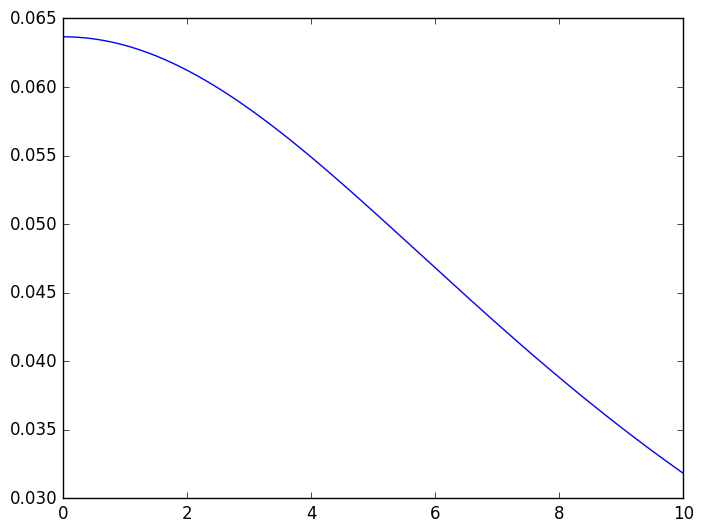

In [60]:
_σf2_prior = Truncated(Cauchy(0.0, 10.0), 0.0, Inf)
_σy2_prior = Truncated(Cauchy(0.0, 10.0), 0.0, Inf)
_L_prior   = Truncated(Cauchy(0.0, 10.0), 0.0, Inf)
_xx = linspace(0.0,10.0,1000)
plt.plot(_xx, pdf(_σf2_prior, _xx))
;

In [61]:
_model = Model(
    σf2 = Stochastic(
        () -> Truncated(Cauchy(0.0, 10.0), 0.0, Inf),
        true
    ),
    σy2 = Stochastic(
        () -> Truncated(Cauchy(0.0, 10.0), 0.0, Inf),
        true
    ),
    L = Stochastic(
        () -> Truncated(Cauchy(0.0, 10.0), 0.0, Inf),
        true
    ),
    Y = Stochastic(1,
        (X, XXt, thresh, στ2, σβ2, σf2, σy2, L) -> MvNormal(
            Distributions.ZeroVector(Float64, n), 
            PDMat(
                g_VarY(X, XXt, thresh, στ2, σβ2, σy2, σf2, L)
            )
        ),
        false
    ),
)

LoadError: LoadError: type ##11#15 has no field code
while loading In[61], in expression starting on line 1

In [20]:
Graph(graph2dot(_model))

LoadError: LoadError: UndefVarError: _model not defined
while loading In[20], in expression starting on line 1

In [21]:
_nuts_scheme = [NUTS([:σf2, :σy2, :L])]
_slice_scheme = [Slice([:σf2, :σy2, :L], 1.0)]
_gibbsslice_scheme = [Slice([:σf2], 1.0), Slice([:σy2], 1.0), Slice([:L], 1.0)]
_data = Dict{Symbol, Any}(
    :X => _X,
    :XXt => Symmetric(_X * _X'),
    :Y => _Y,
    :thresh => 5.0,
    :στ2 => _στ2, 
    :σβ2 => _σβ2,
)
_pr = Truncated(Cauchy(0.0, 10.0), 0.0, Inf)
## Initial Values
inits = [
  Dict{Symbol, Any}(
    :Y => _data[:Y],
    :σy2 => rand(_pr),
    :σf2 => rand(_pr),
    :L => rand(_pr),
  )
for i in 1:3
]
;

LoadError: LoadError: type ##228#231 has no field code
while loading In[21], in expression starting on line 1

In [22]:
setsamplers!(model, gibbsslice_scheme)
sim1 = mcmc(model, data, inits, 1000, burnin=100, thin=2, chains=3)

LoadError: LoadError: UndefVarError: model not defined
while loading In[22], in expression starting on line 1

In [23]:
plot(sim1)[1]

LoadError: LoadError: UndefVarError: sim1 not defined
while loading In[23], in expression starting on line 1

In [24]:
plot(sim1)[2]

LoadError: LoadError: UndefVarError: sim1 not defined
while loading In[24], in expression starting on line 1

In [25]:
plot(sim1)[3]

LoadError: LoadError: UndefVarError: sim1 not defined
while loading In[25], in expression starting on line 1

In [26]:
gelmandiag(sim1)

LoadError: LoadError: UndefVarError: sim1 not defined
while loading In[26], in expression starting on line 1

Not converging at all!

# Toeplitz Structure

Instead of sampling $X$ uniformly from 0 to 10, we will put $X$ on a grid. That way, the Gaussian Process' covariance matrix is Toeplitz, and efficient algorithms exist to invert it.

In [27]:
function kernel{T<:Number,Kern<:GaussianProcesses.Stationary}(kern::Kern, x::LinSpace{T})
    vc = GaussianProcesses.crossKern(x', reshape([0.0,],(1,1)), kern)
    K_ST=SymmetricToeplitz(vec(vc))
    return K_ST
end

kernel (generic function with 2 methods)

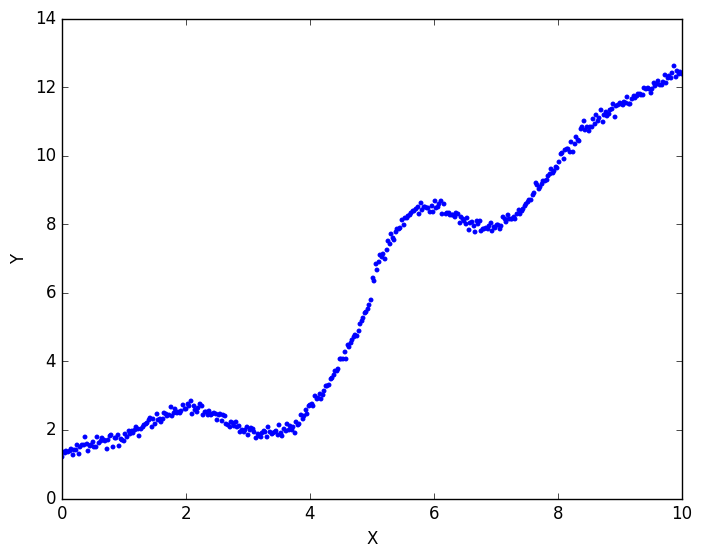

In [28]:
_Xgrid = linspace(0,10,_n_per_region*2)
_Ygrid = simulate1(_βstar, _τstar, _kern, _σy2_star, _thresh, _Xgrid)
plt.plot(_Xgrid, _Ygrid, ".")
plt.xlabel("X")
plt.ylabel("Y")
;

In [29]:
_K_ST = kernel(_kern, _Xgrid)
_K = kernel(_kern, collect(_Xgrid))
;

In [30]:
@assert isapprox(_K, _K_ST, atol=1e-4, norm=Base.LinAlg.vecnormInf)
Base.LinAlg.vecnormInf(_K-_K_ST) # maximum distance

1.765254609153999e-14

In [31]:
typeof(_K_ST)

ToeplitzMatrices.SymmetricToeplitz{Float64}

In [32]:
inv(_K)
@time inv(_K);

  0.009931 seconds (21 allocations: 2.641 MB)


In [33]:
inv(_K_ST)
@time inv(_K_ST);

  0.001055 seconds (21 allocations: 2.458 MB)


Inversion using the Toeplitz structure is about ten times faster. The advantage goes up as the matrix gets larger.

In [34]:
function sherman_morrison{T<:Number}(Ainv::AbstractMatrix{T}, u::AbstractVector{T}, v::AbstractVector{T})
    vT = v'
    α::T = one(T) / (one(T)+(dot(v,Ainv*u)))
    return Ainv - α.*(Ainv*u)*(vT*Ainv)
end

sherman_morrison (generic function with 1 method)

In [35]:
# quick test
@assert isapprox(inv(_K+eye(_n)+3.0*_X*_X'), sherman_morrison(inv(_K+eye(_n)), 3.0*_X,_X))

In [36]:
# function g_VarY{T<:Number, S<:Number}(X::Vector{T}, XXt::Symmetric{T}, thresh::T, στ2::T, σβ2::T, σy2::S, σf2::S, L::S)
#     n = length(X)
#     kern = SE(log(L), log(√σf2))
#     In=eye(Diagonal{Float64},n)
#     region = X.>thresh
#     II = region * region'
#     K = kernel(kern, X)
#     VarY = K + στ2*II + σβ2*XXt + σy2*In + 1e-5*eye(n)
#     return VarY
# end

function g_VarYInv{T<:Number}(ΣGP::SymmetricToeplitz{T}, X::AbstractVector{T}, thresh::T, στ2::T, σβ2::T, σy2::T)
    vc = copy(ΣGP.vc)
    vc[1] += σy2+1e-5
    ΣGP_obs = SymmetricToeplitz(vc)
    ΣGP_inv = inv(ΣGP_obs)
#     ΣGP_inv = inv(full(ΣGP)+eye(n)*σy2)
    ΣGPβ_inv = sherman_morrison(ΣGP_inv, σβ2*X, X)
    region = 1.0.*(X.>thresh) # maybe converting a boolean to a float is stupid
    ΣGPβτ_inv = sherman_morrison(ΣGPβ_inv, στ2*region, region)
    ΣGPβτμ_inv = ΣGPβτ_inv
#     ΣGPβτμ_inv = sherman_morrison(ΣGPβ_inv, σμ2*ones(T,n), ones(T,n))
    return ΣGPβτμ_inv
end
    

g_VarYInv (generic function with 1 method)

In [37]:
g_VarYInv(_K_ST, collect(_Xgrid), _thresh, 2.0, 10.0, 1.5);
@time g_VarYInv(_K_ST, collect(_Xgrid), _thresh, 2.0, 10.0, 1.5);

  0.005472 seconds (204 allocations: 7.437 MB)


In [38]:
inv(g_VarY(collect(_Xgrid), Symmetric(_Xgrid*_Xgrid'), _thresh, _στ2, _σβ2, 1.5, _σf2_star, _Lstar));
@time inv(g_VarY(collect(_Xgrid), Symmetric(_Xgrid*_Xgrid'), _thresh, _στ2, _σβ2, 1.5, _σf2_star, _Lstar));

  0.017982 seconds (1.29 k allocations: 17.357 MB, 10.18% gc time)


In [62]:
# checking that the inverse is correct
@assert isapprox(g_VarYInv(_K_ST, collect(_Xgrid), _thresh, 2.0, 10.0, 1.5)*g_VarY(collect(_Xgrid), Symmetric(_Xgrid*_Xgrid'), _thresh, 2.0, 10.0, 1.5, _σf2_star, _Lstar), eye(_K_ST))

OK, it seems to be doing the right thing.

## Optimisation using Toeplitz

In [40]:
function mvnorm_logpdf{T<:Real, S<:Number}(Σ::AbstractMatrix{S}, Σinv::AbstractMatrix{S}, X::Vector{T})
    c0 = -0.5 * (length(X) * Float64(log2π) + logdet(Σ))
    sqmahal = dot(X, Σinv * X)
    return c0 - 0.5*sqmahal
end

function gen_optim_target{T<:Real}(X::LinSpace{T}, Y::Vector{T}, thresh::T, στ2::T, σβ2::T)
    XXt = Symmetric(X * X') # = BLAS.syrk('U', 'N', 1.0, X)
    function optim_target{T<:Number}(logx::Vector{T})
        σy2, σf2, L = exp(logx)
        kern = SE(log(L), log(σf2))
        K = kernel(kern, X)
        VarY = g_VarY(collect(X), XXt, thresh, στ2, σβ2, σy2, σf2, L)
        VarYInv = g_VarYInv(K, collect(X), thresh, στ2, σβ2, σy2);
        loglik = mvnorm_logpdf(VarY,VarYInv,Y)
        return -loglik
    end
end

gen_optim_target (generic function with 2 methods)

In [41]:
_optim_ST = gen_optim_target(_Xgrid, _Ygrid, 5.0, 10.0, 10.0)

(::optim_target) (generic function with 1 method)

In [42]:
_partial_opt_TS=optimize(_optim_ST, [0.0, 0.0, 0.0], method=:l_bfgs; ftol=0.01, show_every=true, iterations=100);
Profile.clear()
Profile.init(n=10^7,delay=0.01)
@profile _partial_opt_TS=optimize(_optim_ST, [0.0, 0.0, 0.0], method=:l_bfgs; ftol=0.01, show_every=true, iterations=100);

In [43]:
Profile.print(combine=true, format=:flat)

 Count File                        Line Function                               
    16 ./In[12]                       9 g_VarY(::Array{Float64,1}, ::Symmet... 
    28 ./In[12]                      10 g_VarY(::Array{Float64,1}, ::Symmet... 
    40 ./In[12]                      11 g_VarY(::Array{Float64,1}, ::Symmet... 
     2 ./In[27]                       3 kernel(::GaussianProcesses.SEIso, :... 
    28 ./In[2]                       11 kernel(::GaussianProcesses.SEIso, :... 
     3 ./In[34]                       3 sherman_morrison(::Array{Float64,2}... 
    11 ./In[34]                       4 sherman_morrison(::Array{Float64,2}... 
     1 ./In[36]                      15 g_VarYInv(::ToeplitzMatrices.Symmet... 
    15 ./In[36]                      16 g_VarYInv(::ToeplitzMatrices.Symmet... 
    10 ./In[36]                      18 g_VarYInv(::ToeplitzMatrices.Symmet... 
     4 ./In[36]                      20 g_VarYInv(::ToeplitzMatrices.Symmet... 
    55 ./In[40]                       2 

In [78]:
@time _partial_opt_TS=optimize(_optim_ST, [0.0, 0.0, 0.0], method=:l_bfgs; ftol=1e-3, show_every=true, iterations=100);

  2.774277 seconds (275.85 k allocations: 3.643 GB, 11.05% gc time)


In [44]:
_optim_t = gen_optim_target(collect(_Xgrid), _Ygrid, 5.0, 10.0, 10.0)
@time _partial_opt=optimize(_optim_t, [0.0, 0.0, 0.0], method=:l_bfgs; ftol=0.01, show_every=true, iterations=100);

  4.233035 seconds (315.12 k allocations: 3.812 GB, 8.22% gc time)


In [45]:
_partial_opt.minimum

3-element Array{Float64,1}:
 -4.66414 
  0.532191
  0.016453

In [79]:
_partial_opt_TS.minimum

3-element Array{Float64,1}:
 -4.45983
  1.2157 
  0.20777

**Problem**: we're getting different answers optimizing with the Toeplitz structure, and the full structure.

In [46]:
_partial_opt

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimum: [-4.664142358617084,0.5321913006649334, ...]
 * Value of Function at Minimum: -305.096640
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-02: true
   * |g(x)| < 1.0e-08: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 35
 * Gradient Call: 35

In [48]:
_partial_opt_TS

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimum: [-4.459829233925297,1.2157023979424149, ...]
 * Value of Function at Minimum: -305.498905
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-02: true
   * |g(x)| < 1.0e-08: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 24
 * Gradient Call: 24

In [81]:
_optim_ST(_partial_opt_TS.minimum)

-305.4989054455813

In [82]:
_optim_ST(_partial_opt.minimum)

-307.66515694527436

In [83]:
_optim_t(_partial_opt_TS.minimum)

-298.57376665358896

In [84]:
_optim_t(_partial_opt.minimum)

-305.0966399997707

The two functions are different for some reason. Moreover, the minimum using the Toeplitz seems to be suboptimal.

# Autodiff

Auto-differentiation using the DualNumbers package doesn't work well for multivariate analysis.

In [53]:
using ForwardDiff
x = rand(3)
h{T<:Number}(x::Vector{T}) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);
∇h = ForwardDiff.gradient(h)
∇h(x)

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/ForwardDiff.ji for module ForwardDiff.


3-element Array{Float64,1}:
 0.970854
 2.01026 
 0.762912

In [54]:
x = [Dual(2.0,1.0), Dual(3.0,1.0), Dual(2.5, 1.0), Dual(1.3, 1.0)]
XXt = x * x'
cholfact(Symmetric(XXt))

LoadError: LoadError: MethodError: no method matching cholfact(::Symmetric{DualNumbers.Dual{Float64},Array{DualNumbers.Dual{Float64},2}})
Closest candidates are:
  cholfact(::AbstractArray{T,2}, !Matched::Number)
while loading In[54], in expression starting on line 3

In [55]:
realpart(XXt)

4x4 Array{Float64,2}:
 4.0  6.0  5.0   2.6 
 6.0  9.0  7.5   3.9 
 5.0  7.5  6.25  3.25
 2.6  3.9  3.25  1.69

In [56]:
@time optim_t(x);
∇opt = ForwardDiff.gradient(optim_t)
@time ∇opt(x)

LoadError: LoadError: MethodError: no method matching SE(::DualNumbers.Dual{Float64}, ::DualNumbers.Dual{Float64})
while loading In[56], in expression starting on line 155

In [57]:
using Base.LinAlg: chol, chol!
# Linear algebra on dual matrices

# Solve the matrix system
#
#   U'*M + M'*U = B
#
# for M, where B is symmetric and U is upper triangular.  This looks a bit like
# the *-Sylvester equation, but with a lot more structure.  The solution
# algorithm is basically a forward substitution method.
function tri_ss_solve!(M, U, B)
    n = size(U,1)
    # Compute M row by row.  The expression for the i'th row is broken into a
    # part involving matrix products of the previously computed rows of M with
    # parts of U, and a part involving the current row.
    for i = 1:n
        a = B[i,i:end]
        if i > 1
            # Uses only parts of M computed in previous iterations.
            a -= M[1:i-1,i]'*U[1:i-1,i:end] + U[1:i-1,i]'*M[1:i-1,i:end]
        end
        M[i,i] = a[1]/(2*U[i,i])
        println("Uii: ", U[i,i])
        println("Mii: ", M[i,i])
        println("Ui,*:", U[i,i+1:end])
        M[i,i+1:end] = (a[1,2:end] - M[i,i]*U[i,i+1:end]) / U[i,i]
    end
    return M
end

# Version of tri_ss_solve!() optimized for BLAS types
# function tri_ss_solve!{T<:Base.LinAlg.BlasFloat}(M::AbstractMatrix{T},
#                                     U::AbstractMatrix{T}, B::AbstractMatrix{T})
#     n = size(U,1)
#     a = zeros(n)
#     mi = zeros(n)
#     ui = zeros(n)
#     unit = one(T)
#     for i = 1:n
#         m = n-i+1
#         # a[1:m] = B[i,i:n]
#         for k=1:m
#             a[k] = B[i,i+k-1]
#         end
#         if i > 1
#             # a -= M[1:i-1,i]'*U[1:i-1,i:end] + U[1:i-1,i]'*M[1:i-1,i:end]
#             for k=1:i-1
#                 mi[k] = M[k,i]
#                 ui[k] = U[k,i]
#             end
#             # Call BLAS directly to avoid temporary array copies.
#             BLAS.gemv!('T', -unit, sub(U,1:i-1,i:n), mi, unit, a)
#             BLAS.gemv!('T', -unit, sub(M,1:i-1,i:n), ui, unit, a)
#         end
#         M[i,i] = a[1]/(2*U[i,i])
#         # M[i,i+1:end] = (a[1,2:end] - M[i,i]*U[i,i+1:end]) / U[i,i]
#         for k=2:m
#             M[i,i+k-1] = (a[k] - M[i,i]*U[i,i+k-1]) / U[i,i]
#         end
#     end
#     return M
# end

# Cholesky factorization of arrays of dual numbers
#
# The returned matrix is upper triangular
function chol42{T}(A :: AbstractMatrix{Dual{T}})
    U = chol(real(A))
    B = epsilon(A)
    M = zeros(size(A))
    tri_ss_solve!(M, U, B)
    return dual(U,M)
end

chol42 (generic function with 1 method)

In [58]:
Σhat = cov(rand(Normal(), (10000,5)))
Σdual = Array(Dual{Float64}, size(Σhat))
for i in 1:5
    for j in 1:5
        Σdual[i,j] = Dual(Σhat[i,j], 1.0)
    end
end
chol42(Σdual)

 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in real(::DualNumbers.Dual{Float64}) at ./deprecated.jl:50
 [inlined code] from ./boot.jl:331
 in real(::Array{DualNumbers.Dual{Float64},2}) at ./arraymath.jl:26
 in chol42(::Array{DualNumbers.Dual{Float64},2}) at ./In[57]:68
 [inlined code] from ./essentials.jl:80
 in include_string(::UTF8String, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:182
 [inlined code] from ./dict.jl:746
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:142
 in (::IJulia.##24#30)() at ./task.jl:431
while loading In[58], in expression starting on line 8


LoadError: LoadError: MethodError: no method matching one(::Type{Any})
while loading In[58], in expression starting on line 8